In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [52]:
from __future__ import print_function, division
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import glob
import pandas as pd
from openslide import OpenSlide
from torch.utils.data import Dataset
from PIL import Image, ImageOps, ImageEnhance 
from sklearn.model_selection import KFold, StratifiedKFold

class KFold_Data(Dataset):
    #pass main directory to all other patient folders
    def __init__(self, path, csv, list_patients,transform):
        self.files = path
        self.labels_csv = pd.read_csv(csv)
        # self.list_wsi = self.labels_csv['filenames'].tolist()
        self.list_wsi = list_patients
        self.transform = transform
        # self.labels = labels_wsi
        self.data = []
        for i in self.list_wsi:
            # print(i)
            new_path = self.files+i+'_tiles/*'
            # print(new_path)
            all_images = glob.glob(new_path)
            random.shuffle(all_images)
            for patch in all_images:
                # print(self.label_csv[self.labels_csv["filenames"] == (i)]['labels'])
                label = self.labels_csv[self.labels_csv["filenames"] == (i)]['labels'].iloc[0]
                label_conv = 0
                if label.startswith("CKD_noDM"):
                    label_conv=0
                elif label.startswith("HEALTHY"):
                    label_conv=2
                elif label.startswith("DKD"):
                    label_conv=1
                # print(label_conv)
                # print(all_images)
                self.data.append([patch,label_conv])
        # print(self.data)

    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        img, label_conv = self.data[idx]
        name = img
        image = Image.open(img)
        image = self.transform(image)
        return image,label_conv,name
        




data_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [53]:
data_labels = pd.read_csv('/home/tsurendr/Data_labels.csv')
patient_labels = pd.read_csv('/home/tsurendr/patient_labels.csv')
# print(data_labels)
wsi_participants = data_labels['Participant_ID'].tolist()

patient_list = patient_labels['participants'].tolist()
patient_labels_list = patient_labels['labels'].tolist()
print(patient_list)
skf = StratifiedKFold(n_splits = 5, random_state = 7, shuffle = True)
skf.get_n_splits(patient_list, patient_labels_list) 
print(skf)

['17-1606', '18-139', '18-142', '18-162', '27-10039', '27-10042', '29-10006', '29-10007', '29-10011', '29-10012', '29-10013', '29-10016', '29-10277', '31-10001', '31-10035', '31-10040', '31-10042', '31-10061', '31-10078', '31-10063', '31-10000', '31-10006', '31-10007', '29-10008']
StratifiedKFold(n_splits=5, random_state=7, shuffle=True)


In [54]:
VALIDATION_ACCURACY = []
VALIDAITON_LOSS = []
PATH = "Three_label_classifier_patient_level_resnet50_with_adam_KFold_5.pt"
class_names = ('CKD_noDM','Has_DKD', 'HEALTHY')
for train_ids, test_ids in skf.split(patient_list,patient_labels_list):
    training_wsi = []
    testing_wsi = []
    # print(train_ids)
    # print(test_ids)
    for i in (train_ids):
        # print(data_labels.query())
        df = data_labels.loc[data_labels['Participant_ID'] == patient_list[i]]
        wsi_list = df['filenames'].tolist()
        for j in wsi_list:
            training_wsi.append(j)
        
    for i in (test_ids):
        # print(data_labels.query())
        df = data_labels.loc[data_labels['Participant_ID'] == patient_list[i]]
        wsi_list = df['filenames'].tolist()
        for j in wsi_list:
            testing_wsi.append(j)
    # 
    # 
    image_datasets_train = KFold_Data('/data1/DKDimages/All_patch_Folders/', '/home/tsurendr/Data_labels.csv', training_wsi, data_transforms)
    # print(len(image_datasets_train))
    
    image_datasets_val = KFold_Data('/data1/DKDimages/All_patch_Folders/', '/home/tsurendr/Data_labels.csv', testing_wsi,  data_transforms)
    # print(len(image_datasets_train))
    dataloader_train = torch.utils.data.DataLoader(image_datasets_train, batch_size=4,
                                             shuffle=True, num_workers=8)
    dataloader_val = torch.utils.data.DataLoader(image_datasets_val, batch_size=4,
                                             shuffle=True, num_workers=8)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    dataset_sizes_train = len(image_datasets_train)
    dataset_sizes_val = len(image_datasets_val)
    #final layer ########################

    model_conv = torchvision.models.resnet50(pretrained=True)
    for param in model_conv.parameters():
        param.requires_grad = False

    # Parameters of newly constructed modules have requires_grad=True by default
    model_conv.outlayer = nn.Linear(512 * 1 * 1, 3)
    num_ftrs = model_conv.fc.in_features
    model_conv.fc = nn.Linear(num_ftrs, len(class_names))

    model_conv = model_conv.to(device)

    criterion = nn.CrossEntropyLoss()

    # Observe that only parameters of final layer are being optimized as
    # opposed to before.
    # optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
    ##### Adam Optimizer
    optimizer = optim.Adam(model_conv.parameters(), lr=0.001)
    # Decay LR by a factor of 0.1 every 7 epochs
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    since = time.time()
#     print("hello")
    best_model_wts = copy.deepcopy(model_conv.state_dict())
    best_acc = 0.0
    num_epochs = 25
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model_conv.train()  # Set model to training mode
            else:
                model_conv.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            if phase == "train":
                
                for inputs, labels, paths in dataloader_train:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
#                     print(min(labels))
#                     print(max(labels))
#                     print(inputs.shape)
        
                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model_conv(inputs)
                        _, preds = torch.max(outputs, 1)
#                         print(torch.max(outputs, 1))
#                         print(torch.min(outputs, 1))
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
            
            
            if phase == "val":
                
                for inputs, labels, paths in dataloader_val:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model_conv(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()
            if phase == 'train':
                epoch_loss = running_loss / dataset_sizes_train
                epoch_acc = running_corrects.double() / dataset_sizes_train
            if phase == 'val':
                epoch_loss = running_loss / dataset_sizes_val
                epoch_acc = running_corrects.double() / dataset_sizes_val
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model_conv.state_dict())
                
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model_conv.load_state_dict(best_model_wts)
    torch.save(model_conv, PATH)




/home/tsurendr/venv/dpd/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


7200
3600
10365
validation set length:  3600
Train Loader size:  1800
Val Loader size:  900
Test Loader size:  2592


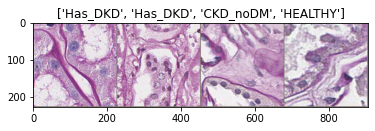

In [6]:
# Training 25672 Total - 13000 Healthy / 11000 Has_DKD / 1,700 CKD_noDM
# Validation 18071 Total - 15,988 Healthy / 1879 Has_DKD / 204 CKD_noDM
# Testing 14861 Total - 11,470 Healthy / 2318 Has_DKD / 1,073 CKD_noDM
PATH = "Three_label_classifier_patient_level_500_patch_resnet50_with_adam.pt"
# Try to find an equal number of patches from each set do better sampling

plt.ion()   # interactive mode

temp_DKD = glob.glob('/data1/DKDimages/Three_Label_WSI/KPMP_WSI/Has_DKD/*')
wsi_HasDKD = []
wsi_all = []
for x in temp_DKD:
    
    dkd_split = x.split("/")[-1].split(".")[0].split('_')[0]
#     print(dkd_split)
    wsi_HasDKD.append(dkd_split)
    wsi_all.append(dkd_split)
# print("has DKD",wsi_HasDKD)
# print(len(wsi_HasDKD))
temp_Healthy = glob.glob('/data1/DKDimages/Three_Label_WSI/KPMP_WSI/Healthy/*')
wsi_Healthy = []
for x in temp_Healthy:
    
    dkd_split = x.split("/")[-1].split(".")[0].split('_')[0]
#     print(dkd_split)
    wsi_Healthy.append(dkd_split)
    wsi_all.append(dkd_split)
# print("Healthy",wsi_Healthy)
# print(len(wsi_Healthy))
# print(wsi_all)
# print("all len",len(wsi_all))

temp_CKD_noDM = glob.glob('/data1/DKDimages/Three_Label_WSI/KPMP_WSI/CKD_noDM/*')
wsi_CKD_noDM = []
for x in temp_CKD_noDM:
    
    dkd_split = x.split("/")[-1].split(".")[0].split('_')[0]
#     print(dkd_split)
    wsi_CKD_noDM.append(dkd_split)
    wsi_all.append(dkd_split)
# print("ckd",wsi_CKD_noDM)
# print(len(wsi_CKD_noDM))


# print(wsi_all)
# print("all len",len(wsi_all))
# wsi_dict = dict()
# for i in wsi_all:
#     wsi_dict[i] = dict()
#     wsi_dict[i]["Healthy"] = 0
#     wsi_dict[i]["Has_DKD"] = 0
#     wsi_dict[i]["CKD_noDM"] = 0
# print(wsi_dict)


params = {'batch_size': 4,
          'shuffle': True,
          'num_workers': 8}

class_names = ('CKD_noDM','Has_DKD', 'HEALTHY')

image_datasets_train = Training_MyDaatset('/data1/DKDimages/All_patch_Folders/', '/home/tsurendr/Train_labels.csv',  data_transforms)
print(len(image_datasets_train))
image_datasets_val = Training_MyDaatset('/data1/DKDimages/All_patch_Folders/', '/home/tsurendr/Val_labels.csv', data_transforms)
print(len(image_datasets_val))
image_datasets_test = MyDaatset('/data1/DKDimages/All_patch_Folders/','/home/tsurendr/Test_labels.csv', data_transforms)
print(len(image_datasets_test))
print(image_datasets_val)
print("validation set length: ", len(image_datasets_val))
dataloader_train = torch.utils.data.DataLoader(image_datasets_train, batch_size=4,
                                             shuffle=True, num_workers=8)
print(dataloader_train)
dataloader_val = torch.utils.data.DataLoader(image_datasets_val, batch_size=4,
                                             shuffle=True, num_workers=8)
dataloader_test = torch.utils.data.DataLoader(image_datasets_test, batch_size=4,
                                             shuffle=True, num_workers=8)

print("Train Loader size: ", len(dataloader_train))
print("Val Loader size: ", len(dataloader_val))
print("Test Loader size: ", len(dataloader_test))
dataset_sizes_train = len(image_datasets_train)
dataset_sizes_val = len(image_datasets_val)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
path_sum = 0
# for i, data in enumerate(dataloader_val):
#     images,labels,paths = data
# #     print( paths[3])
#     if paths[0]: 
#         path_sum+=1
#         print("path 0", paths[0], labels[0],class_names[labels[0]])
#     if paths[1]:
#         path_sum+=1
#         print("path 1", paths[1], labels[1],class_names[labels[1]])
        
#     try:
#         if paths[2]:
#             path_sum+=1
#             print("path 2", paths[2],labels[2], class_names[labels[2]])
            
#     except IndexError:
#         pass
    
#     try:
#         if paths[3]:
#             path_sum+=1
#             print("path 3", paths[3], labels[3],class_names[labels[3]])
            
#     except IndexError:
#         pass
# print("done")
# print(path_sum)
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# # Get a batch of training data
inputs, classes, paths = next(iter(dataloader_train))
# print(classes)
# print(inputs)
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])



In [8]:

def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
#     print("hello")
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            if phase == "train":
                
                for inputs, labels, paths in dataloader_train:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
#                     print(min(labels))
#                     print(max(labels))
#                     print(inputs.shape)
        
                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
#                         print(torch.max(outputs, 1))
#                         print(torch.min(outputs, 1))
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
            
            
            if phase == "val":
                
                for inputs, labels, paths in dataloader_val:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()
            if phase == 'train':
                epoch_loss = running_loss / dataset_sizes_train
                epoch_acc = running_corrects.double() / dataset_sizes_train
            if phase == 'val':
                epoch_loss = running_loss / dataset_sizes_val
                epoch_acc = running_corrects.double() / dataset_sizes_val
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model, PATH)
    return model

#final layer ########################

model_conv = torchvision.models.resnet50(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
model_conv.outlayer = nn.Linear(512 * 1 * 1, 3)
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
# optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
##### Adam Optimizer
optimizer_conv = optim.Adam(model_conv.parameters(), lr=0.001)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)



Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/tsurendr/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Epoch 0/24
----------
train Loss: 0.4420 Acc: 0.8260
val Loss: 0.3081 Acc: 0.8839

Epoch 1/24
----------
train Loss: 0.3501 Acc: 0.8682
val Loss: 0.1774 Acc: 0.9392

Epoch 2/24
----------
train Loss: 0.3481 Acc: 0.8662
val Loss: 0.2802 Acc: 0.9017

Epoch 3/24
----------
train Loss: 0.3751 Acc: 0.8644
val Loss: 0.2895 Acc: 0.9097

Epoch 4/24
----------
train Loss: 0.3364 Acc: 0.8793
val Loss: 0.3120 Acc: 0.9019

Epoch 5/24
----------
train Loss: 0.2985 Acc: 0.8907
val Loss: 0.3326 Acc: 0.8806

Epoch 6/24
----------
train Loss: 0.3123 Acc: 0.8850
val Loss: 0.2254 Acc: 0.9236

Epoch 7/24
----------
train Loss: 0.2412 Acc: 0.9118
val Loss: 0.2619 Acc: 0.9231

Epoch 8/24
----------
train Loss: 0.2516 Acc: 0.9024
val Loss: 0.2628 Acc: 0.9214

Epoch 9/24
----------
train Loss: 0.2283 Acc: 0.9133
val Loss: 0.2611 Acc: 0.9164

Epoch 10/24
----------
train Loss: 0.2254 Acc: 0.9190
val Loss: 0.2275 Acc: 0.9142

Epoch 11/24
----------
train Loss: 0.2323 Acc: 0.9117
val Loss: 0.2340 Acc: 0.9269

Ep

In [8]:
import seaborn as sns
def visualize_model(model,dataloader):
    wsi_dict = dict()
    for i in wsi_all:
        wsi_dict[i] = dict()
        wsi_dict[i]["Healthy"] = 0
        wsi_dict[i]["Has_DKD"] = 0
        wsi_dict[i]["CKD_noDM"] = 0
    # print(wsi_dict)
    # print(len(dataloader))
    was_training = model.training
    model.eval()
    # images_so_far = 0
    # fig = plt.figure()
    path_sum = 0
    len_class_names = len(class_names)
    confusion_matrix = torch.zeros(len_class_names, len_class_names)
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            inputs, labels, filenames = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            # print(labels) 

            outputs = model(inputs)
            # print(torch.sigmoid(outputs)[0])
            _, preds = torch.max(outputs, 1)
            # print(preds[0])
#             print(filenames)
            try:
                if filenames[0]: 
                    path_sum+=1
#                     print("path 0", filenames[0])
                    print("prediction: ", class_names[preds[0]])
                    temp = filenames[0].split("/")[-1].split(".")[0].split('_')[0]
    #                 dict_key = temp[0]+"_"+temp[1]+"_"+temp[2]+"_"+temp[3]
                    dict_key = temp
    #                 print(dict_key)
                    if dict_key in wsi_all:
                        if class_names[preds[0]] == "Has_DKD":
                            wsi_dict[dict_key]["Has_DKD"] += 1
                            # print(dict_key,wsi_dict[dict_key]["Has_DKD"])
                        elif class_names[preds[0]] == "HEALTHY":
                            wsi_dict[dict_key]["Healthy"] += 1
                            # print(dict_key,wsi_dict[dict_key]["Healthy"])
                        elif class_names[preds[0]] == "CKD_noDM":
                            wsi_dict[dict_key]["CKD_noDM"] += 1
                            # print( dict_key,wsi_dict[dict_key]["CKD_noDM"])
            except IndexError:
                pass
            try:
                
                if filenames[1]:
                    path_sum+=1
#                     print("path 1", filenames[1])
                    print("prediction: ", class_names[preds[1]])
                    temp = filenames[1].split("/")[-1].split(".")[0].split('_')[0]
    #                 dict_key = temp[0]+"_"+temp[1]+"_"+temp[2]+"_"+temp[3]
                    dict_key = temp
    #                 print(dict_key)                
                    if dict_key in wsi_all:
                        if class_names[preds[1]] == "Has_DKD":
                            wsi_dict[dict_key]["Has_DKD"] += 1
                            # print(dict_key,wsi_dict[dict_key]["Has_DKD"])
                        elif class_names[preds[1]] == "HEALTHY":
                            wsi_dict[dict_key]["Healthy"] += 1
                            # print(dict_key,wsi_dict[dict_key]["Healthy"])
                        elif class_names[preds[1]] == "CKD_noDM":
                            wsi_dict[dict_key]["CKD_noDM"] += 1
                            # print( dict_key,wsi_dict[dict_key]["CKD_noDM"])
    #             print(filenames[2])
            except IndexError:
                pass
            try:
                if filenames[2]:
                    path_sum+=1
#                     print("path 2", filenames[2])
                    print("prediction: ", class_names[preds[2]])
                    temp = filenames[2].split("/")[-1].split(".")[0].split('_')[0]
                    dict_key = temp
#                     dict_key = temp[0]+"_"+temp[1]+"_"+temp[2]+"_"+temp[3]
#                     print(dict_key)                    
                    if dict_key in wsi_all:
                        if class_names[preds[2]] == "Has_DKD":
                            wsi_dict[dict_key]["Has_DKD"] += 1
                            # print(dict_key,wsi_dict[dict_key]["Has_DKD"])
                        elif class_names[preds[2]] == "HEALTHY":
                            wsi_dict[dict_key]["Healthy"] += 1
                            # print(dict_key,wsi_dict[dict_key]["Healthy"])
                        elif class_names[preds[2]] == "CKD_noDM":
                            wsi_dict[dict_key]["CKD_noDM"] += 1
                            # print( dict_key,wsi_dict[dict_key]["CKD_noDM"])
            except IndexError:
                pass

            try:
                if filenames[3]:
                    path_sum+=1
#                     print("path 3", filenames[3])
                    print("prediction: ", class_names[preds[3]])
                    temp = filenames[3].split("/")[-1].split(".")[0].split('_')[0]
                    dict_key = temp
#                     dict_key = temp[0]+"_"+temp[1]+"_"+temp[2]+"_"+temp[3]
#                     print(dict_key)
                    if dict_key in wsi_all:
                        if class_names[preds[3]] == "Has_DKD":
                            wsi_dict[dict_key]["Has_DKD"] += 1
                            # print(dict_key,wsi_dict[dict_key]["Has_DKD"])
                        elif class_names[preds[3]] == "HEALTHY":
                            wsi_dict[dict_key]["Healthy"] += 1
                            # print(dict_key,wsi_dict[dict_key]["Healthy"])
                        elif class_names[preds[3]] == "CKD_noDM":
                            wsi_dict[dict_key]["CKD_noDM"] += 1
                            # print( dict_key,wsi_dict[dict_key]["CKD_noDM"])
            except IndexError:
                pass
        
            for t, p in zip(labels.view(-1), preds.view(-1)):
                            confusion_matrix[t.long(), p.long()] += 1

#             print(filenames[0])
#             [print(class_names[x]) for x in preds]
        
#             for j in range(inputs.size()[0]):
#                 images_so_far += 1
#                 ax = plt.subplot(num_images//2, 2, images_so_far)
#                 ax.axis('off')
#                 ax.set_title('predicted: {}'.format(class_names[preds[j]]))
#                 imshow(inputs.cpu().data[j])

#                 if images_so_far == num_images:
#                     model.train(mode=was_training)
#                     return
#         print(confusion_matrix)
#         print(confusion_matrix.diag()/confusion_matrix.sum(1))

#         sns.heatmap(confusion_matrix, annot=True)
        print("path_sum: ",path_sum)

        ax= plt.subplot()
        sns.heatmap(confusion_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
        
        # labels, title and ticks
        ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
        ax.set_title('Confusion Matrix'); 
        ax.xaxis.set_ticklabels(['CKD_noDM', 'Has_DKD','Healthy']); ax.yaxis.set_ticklabels(['CKD_noDM', 'Has_DKD','Healthy'])
        print('Predicted label accuracy',(confusion_matrix.diag()/confusion_matrix.sum(1)))
        model.train(mode=was_training)
        return wsi_dict

       

prediction:  HEALTHY
prediction:  HEALTHY
prediction:  Has_DKD
prediction:  HEALTHY
prediction:  HEALTHY
prediction:  HEALTHY
prediction:  HEALTHY
prediction:  HEALTHY
prediction:  HEALTHY
prediction:  HEALTHY
prediction:  HEALTHY
prediction:  HEALTHY
prediction:  HEALTHY
prediction:  HEALTHY
prediction:  HEALTHY
prediction:  HEALTHY
prediction:  HEALTHY
prediction:  HEALTHY
prediction:  HEALTHY
prediction:  HEALTHY
prediction:  HEALTHY
prediction:  Has_DKD
prediction:  HEALTHY
prediction:  HEALTHY
prediction:  HEALTHY
prediction:  HEALTHY
prediction:  HEALTHY
prediction:  HEALTHY
prediction:  HEALTHY
prediction:  Has_DKD
prediction:  HEALTHY
prediction:  HEALTHY
prediction:  HEALTHY
prediction:  Has_DKD
prediction:  HEALTHY
prediction:  HEALTHY
prediction:  HEALTHY
prediction:  HEALTHY
prediction:  Has_DKD
prediction:  HEALTHY
prediction:  HEALTHY
prediction:  HEALTHY
prediction:  HEALTHY
prediction:  HEALTHY
prediction:  HEALTHY
prediction:  HEALTHY
prediction:  HEALTHY
prediction:  

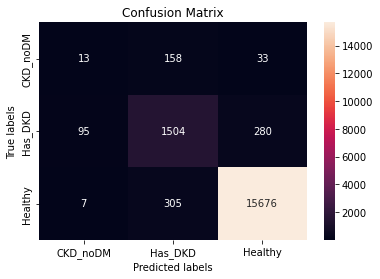

In [9]:
model = torch.load(PATH)
model.eval()
wsi_dict = visualize_model(model,dataloader_val)
print("Validation Slide Status: ")
# print(wsi_all)
for k in wsi_all:
#     print(k)
    print("WSI: ", k, " healthy: ", wsi_dict[k]['Healthy'], "has DKD: ", wsi_dict[k]['Has_DKD'],"CKD_noDM" ,wsi_dict[k]['CKD_noDM'], "total patch num", wsi_dict[k]['Healthy'] + wsi_dict[k]['CKD_noDM'] + wsi_dict[k]['Has_DKD'])
    if (max(wsi_dict[k]['Healthy'], wsi_dict[k]['Has_DKD'],wsi_dict[k]['CKD_noDM']) == wsi_dict[k]['Healthy']) and (wsi_dict[k]['Healthy'] != 0 or wsi_dict[k]['Has_DKD'] != 0 or wsi_dict[k]['CKD_noDM'] != 0 ):
        print("WSI: ", k, "Status: Healthy" )
    elif max(wsi_dict[k]['Healthy'], wsi_dict[k]['Has_DKD'],wsi_dict[k]['CKD_noDM']) == wsi_dict[k]['Has_DKD'] and (wsi_dict[k]['Healthy'] != 0 or wsi_dict[k]['Has_DKD'] != 0 or wsi_dict[k]['CKD_noDM'] != 0 ):
        print("WSI: ", k, "Status: Has_DKD" )
    elif max(wsi_dict[k]['Healthy'], wsi_dict[k]['Has_DKD'],wsi_dict[k]['CKD_noDM']) == wsi_dict[k]['CKD_noDM'] and (wsi_dict[k]['Healthy'] != 0 or wsi_dict[k]['Has_DKD'] != 0 or wsi_dict[k]['CKD_noDM'] != 0 ):
        print("WSI: ", k, "Status: CKD_noDM" )
plt.ioff()
plt.show() 

prediction:  HEALTHY
prediction:  HEALTHY
prediction:  Has_DKD
prediction:  CKD_noDM
prediction:  HEALTHY
prediction:  Has_DKD
prediction:  HEALTHY
prediction:  HEALTHY
prediction:  Has_DKD
prediction:  Has_DKD
prediction:  Has_DKD
prediction:  Has_DKD
prediction:  HEALTHY
prediction:  Has_DKD
prediction:  HEALTHY
prediction:  Has_DKD
prediction:  Has_DKD
prediction:  HEALTHY
prediction:  HEALTHY
prediction:  HEALTHY
prediction:  Has_DKD
prediction:  HEALTHY
prediction:  Has_DKD
prediction:  Has_DKD
prediction:  HEALTHY
prediction:  HEALTHY
prediction:  Has_DKD
prediction:  Has_DKD
prediction:  HEALTHY
prediction:  HEALTHY
prediction:  Has_DKD
prediction:  HEALTHY
prediction:  Has_DKD
prediction:  HEALTHY
prediction:  Has_DKD
prediction:  HEALTHY
prediction:  Has_DKD
prediction:  HEALTHY
prediction:  Has_DKD
prediction:  HEALTHY
prediction:  Has_DKD
prediction:  Has_DKD
prediction:  CKD_noDM
prediction:  Has_DKD
prediction:  HEALTHY
prediction:  Has_DKD
prediction:  HEALTHY
prediction:

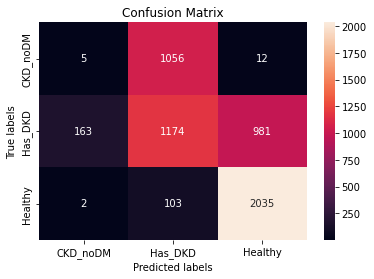

In [10]:
wsi_dict = visualize_model(model,dataloader_test)    
print("Testing status: ")
# print(wsi_all)
for k in wsi_all:
#     print(k)
    print("WSI: ", k, " healthy: ", wsi_dict[k]['Healthy'], "has DKD: ", wsi_dict[k]['Has_DKD'],"CKD_noDM" ,wsi_dict[k]['CKD_noDM'], "total patch num", wsi_dict[k]['Healthy'] + wsi_dict[k]['CKD_noDM'] + wsi_dict[k]['Has_DKD'])
    if (max(wsi_dict[k]['Healthy'], wsi_dict[k]['Has_DKD'],wsi_dict[k]['CKD_noDM']) == wsi_dict[k]['Healthy']) and (wsi_dict[k]['Healthy'] != 0 or wsi_dict[k]['Has_DKD'] != 0 or wsi_dict[k]['CKD_noDM'] != 0 ):
        print("WSI: ", k, "Status: Healthy" )
    elif max(wsi_dict[k]['Healthy'], wsi_dict[k]['Has_DKD'],wsi_dict[k]['CKD_noDM']) == wsi_dict[k]['Has_DKD'] and (wsi_dict[k]['Healthy'] != 0 or wsi_dict[k]['Has_DKD'] != 0 or wsi_dict[k]['CKD_noDM'] != 0 ):
        print("WSI: ", k, "Status: Has_DKD" )
    elif max(wsi_dict[k]['Healthy'], wsi_dict[k]['Has_DKD'],wsi_dict[k]['CKD_noDM']) == wsi_dict[k]['CKD_noDM'] and (wsi_dict[k]['Healthy'] != 0 or wsi_dict[k]['Has_DKD'] != 0 or wsi_dict[k]['CKD_noDM'] != 0 ):
        print("WSI: ", k, "Status: CKD_noDM" )

In [12]:
import pandas as pd
from openslide import OpenSlide
df_labels = pd.read_csv("Test_labels.csv")
df_labels

filenames   labels
0   502d2911-4815-44e0-b66f-b1910e8808e9_S-1910-00...    H-CKD
1   dbdcd9a2-62a7-4988-86a2-90cf1ea57242_S-1910-00...    H-CKD
2   5d07f47b-dd32-4c09-92ea-fd084f4ca2e8_18-162_PA...  HEALTHY
3   829067a5-eda4-415d-8e2e-fa9a15ac583c_18-162_PA...  HEALTHY
4   61a1c11d-d869-4868-ba9b-5f31fbd1dbff_18-162_PA...  HEALTHY
5   7daf471c-957e-4ebf-a206-bc0fef11cf2f_18-162_PA...  HEALTHY
6   760649cb-be20-4559-8f29-5fb4a3225e43_18-162_PA...  HEALTHY
7   16dc8e6f-524c-48cb-9252-46140fd74090_18-162_PA...  HEALTHY
8   2fda166d-a6d0-46a7-acfa-124e0e51dce2_S-2001-01...      DKD
9   060e75ad-0819-4007-b5bc-18a39dbcefdd_S-2001-01...      DKD
10  59eaa15d-a1d5-4990-93bc-7b53b590fab5_S-2006-00...      DKD
11  f1f7bccc-feb9-42fe-a76c-8a488e6b1986_S-2006-00...      DKD
12  a71eff4a-4751-423f-91aa-c273ea6c08cf_S-2001-00...      DKD
13  e6c166fd-0b8b-4dbe-8fea-7fd3310d9243_S-2001-00...      DKD

In [14]:
from torch.utils.data import Dataset
class newSet(Dataset):
    def __init__(self, path, labels_wsi,transform):
        self.files = glob.glob(path)
        print(type(self.files))
        self.transform = transform
        self.labels = labels_wsi
    def __getitem__(self, item):
        file = self.files[item]
        name = file
        label = self.labels
        file = Image.open(file)
        file = self.transform(file)
        if label.startswith("CKD_noDM"):
            label=0
        elif label.startswith("HEALTHY"):
            label=2
        elif label.startswith("DKD"):
            label=1
        return file,label,name
    def __len__(self):
        return len(self.files)


print("hei")


hei


In [15]:
#so i pass a wsi into the function
# inside the function i get the size of the wsi as well as the tsv and patches for it
# so the data loader essentially tests only the values of 1 image at a time.
from PIL import Image, ImageOps, ImageEnhance 
import openslide
import math
def slide_to_scaled_pil_image(slide, SCALE_FACTOR):

    large_w, large_h = slide.dimensions
    new_w = math.floor(large_w / SCALE_FACTOR)
    new_h = math.floor(large_h / SCALE_FACTOR)
    level = slide.get_best_level_for_downsample(SCALE_FACTOR)
    whole_slide_image = slide.read_region((0, 0), level, slide.level_dimensions[level])
    whole_slide_image = whole_slide_image.convert("RGB")
    img = whole_slide_image.resize((new_w, new_h), Image.BILINEAR)
    return img, large_w, large_h, new_w, new_h


060e75ad-0819-4007-b5bc-18a39dbcefdd_S-2001-019412_PAS_2of2
DKD
/data1/DKDimages/ALL_WSI/060e75ad-0819-4007-b5bc-18a39dbcefdd_S-2001-019412_PAS_2of2.svs
True
(77726, 37463)
(2428, 1170)
True
/data1/DKDimages/All_patch_Folders/060e75ad-0819-4007-b5bc-18a39dbcefdd_S-2001-019412_PAS_2of2_tiles/*
False
<class 'list'>
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
503


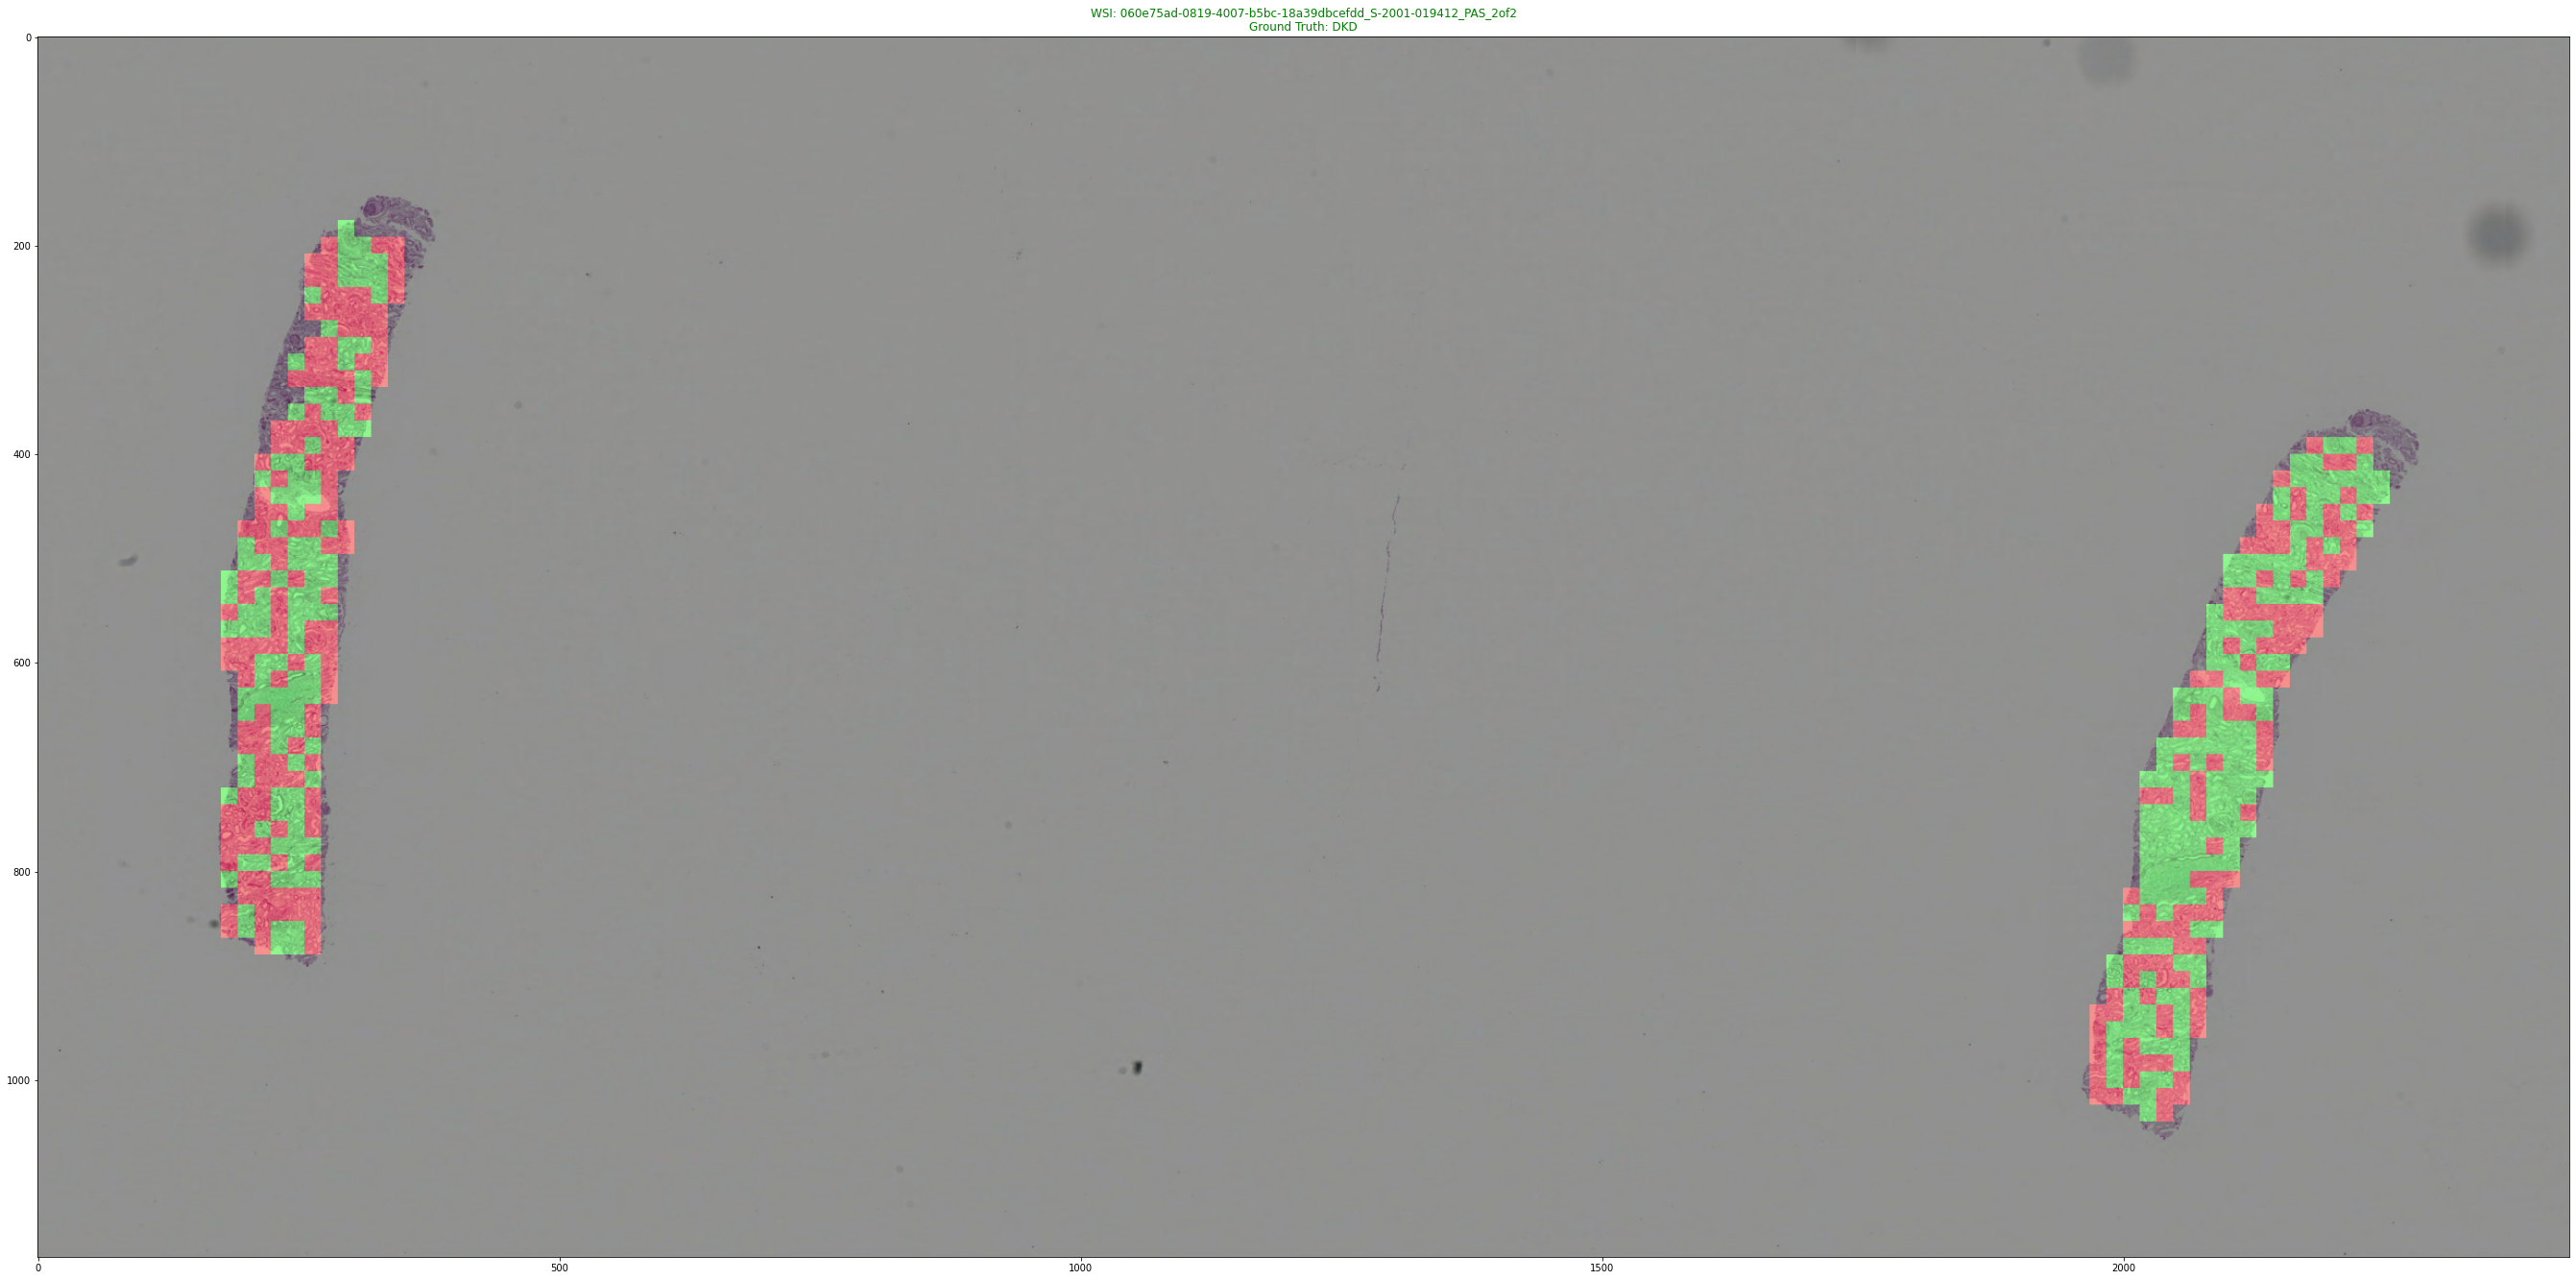

In [44]:



def heatmap_generation(model,wsi_name,label):
    SCALE_FACTOR=32
    wsi_path = '/data1/DKDimages/ALL_WSI/'+wsi_name+'.svs'
    print(wsi_path)
    print(os.path.exists(wsi_path))
    wsi_image = OpenSlide(wsi_path)
    # pilImage = Image.open(wsi_path)
    img = openslide.OpenSlide(wsi_path)
    ds_img, large_w, large_h, new_w, new_h = slide_to_scaled_pil_image(img, SCALE_FACTOR)
    ds_img.save("test.png")
    # image = openslide.open_slide(wsi_path)
    # new_IM = Image.convert(image)
    # print(image.dimensions)
    path_sum = 0
    
    print(wsi_image.dimensions)
    print(ds_img.size)
    target_size = ds_img.size
    heat_map = Image.new('RGB', target_size)
    tsv_loc = '/data1/DKDimages/Pyhist_WSI_Image_Coords/' + wsi_name+ '/tile_selection.tsv'
    print(os.path.exists(tsv_loc))
    patch_loc = '/data1/DKDimages/All_patch_Folders/' + wsi_name+'_tiles/*'
    print(patch_loc)
    print(os.path.exists(patch_loc))
    tsv_coords = pd.read_csv(tsv_loc,sep='\t')
    # print(tsv_coords)
    # print(glob.glob(patch_loc+'/*'))
    temp = newSet(patch_loc, labels_wsi = label,transform=data_transforms)
    # print(len(temp))
    # image_datasets_test_new = tempFolder('/data1/DKDimages/All_patch_Folders/502d2911-4815-44e0-b66f-b1910e8808e9_S-1910-000043_PAS_1of2_tiles',labels = label,transform = data_transforms)
    dataloader_test_new = torch.utils.data.DataLoader(temp, batch_size=4,
                                             shuffle=False, num_workers=8)  
    model.eval()

    with torch.no_grad():
        for i, data in enumerate(dataloader_test_new):
            inputs, labels, filenames = data
            # print(inputs,labels,filenames)
            # print(type(labels))
            inputs = inputs.to(device)
            labels = labels.to(device)
              

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
        
            # print(preds)
            try:
                if filenames[0]: 
                    path_sum+=1
                    # print("path 0", filenames[0])
                    # print("prediction: ", class_names[preds[0]])
                    temp = filenames[0].split("/")[-1].split(".")[0]
    #                 dict_key = temp[0]+"_"+temp[1]+"_"+temp[2]+"_"+temp[3]
                    dict_key = temp
                    # print(dict_key)

                    if class_names[preds[0]] == "Has_DKD":
                        # heat = np.full(shape=(512, 512,3),fill_value=(0,0,255)).astype(np.uint32)
                        # heat = Image.fromarray((heat * 255).astype(np.uint8)) 
                        heat = Image.new('RGB',(int(512/SCALE_FACTOR),int(512/SCALE_FACTOR)),(255,0,0))
                    elif class_names[preds[0]] == "HEALTHY":
                        # heat = np.full(shape=(512, 512,3),fill_value=(0,255,0)).astype(np.uint32)
                        # heat = Image.fromarray((heat * 255).astype(np.uint8))
                        heat = Image.new('RGB',(int(512/SCALE_FACTOR),int(512/SCALE_FACTOR)),(0,255,0)) 
                    elif class_names[preds[0]] == "CKD_noDM":
                        # heat = np.full(shape=(512, 512,3),fill_value=(255,0,0)).astype(np.uint32)
                        # heat = Image.fromarray((heat * 255).astype(np.uint8))
                        heat = Image.new('RGB',(int(512/SCALE_FACTOR),int(512/SCALE_FACTOR)),(0,0,255)) 
                    # heat = Image.new('RGB',(512,512),(255,0,0))
                    # heat.save("just_img.png")
                    if (tsv_coords[tsv_coords["Tile"] == (dict_key)]['Keep'].iloc[0] == 1):
                        
                        x = int((tsv_coords[tsv_coords["Tile"] == (dict_key)]['Column'].iloc[0])*int(512)/SCALE_FACTOR)
                        y = int((tsv_coords[tsv_coords["Tile"] == (dict_key)]['Row'].iloc[0])*int(512)/SCALE_FACTOR)
                        # print((tsv_coords[tsv_coords["Tile"] == (dict_key)]['Keep'].iloc[0])) 
                        heat_map.paste(im=heat, box=(x,y))

                    # print(x,y)
            except IndexError:
                pass
            try:
                
                if filenames[1]:
                    path_sum+=1
                    # print("path 1", filenames[1])
                    # print("prediction: ", class_names[preds[1]])
                    temp = filenames[1].split("/")[-1].split(".")[0]
                    dict_key = temp
                    # print(dict_key)                

                    if class_names[preds[1]] == "Has_DKD":
                        #  heat = np.full(shape=(512, 512,3),fill_value=(0,0,255)).astype(np.uint32)
                        #  heat = Image.fromarray((heat * 255).astype(np.uint8))
                         heat = Image.new('RGB',(int(512/SCALE_FACTOR),int(512/SCALE_FACTOR)),(255,0,0)) 
                    elif class_names[preds[1]] == "HEALTHY":
                        #  heat = np.full(shape=(512, 512,3),fill_value=(0,255,0)).astype(np.uint32)
                        #  heat = Image.fromarray((heat * 255).astype(np.uint8))
                         heat = Image.new('RGB',(int(512/SCALE_FACTOR),int(512/SCALE_FACTOR)),(0,255,0)) 
                    elif class_names[preds[1]] == "CKD_noDM":
                        #  heat = np.full(shape=(512, 512,3),fill_value=(255,0,0)).astype(np.uint32)
                        #  heat = Image.fromarray((heat * 255).astype(np.uint8))
                         heat = Image.new('RGB',(int(512/SCALE_FACTOR),int(512/SCALE_FACTOR)),(0,0,255)) 
                    
                    if (tsv_coords[tsv_coords["Tile"] == (dict_key)]['Keep'].iloc[0] == 1):
                        
                        x = int((tsv_coords[tsv_coords["Tile"] == (dict_key)]['Column'].iloc[0])*int(512)/SCALE_FACTOR)
                        y = int((tsv_coords[tsv_coords["Tile"] == (dict_key)]['Row'].iloc[0])*int(512)/SCALE_FACTOR)
                        # print((tsv_coords[tsv_coords["Tile"] == (dict_key)]['Keep'].iloc[0])) 
                        heat_map.paste(im=heat, box=(x,y))
                    
    #             print(filenames[2])
            except IndexError:
                pass
            try:
                if filenames[2]:
                    path_sum+=1
                    # print("path 2", filenames[2])
                    # print("prediction: ", class_names[preds[2]])
                    temp = filenames[2].split("/")[-1].split(".")[0]
                    dict_key = temp
#                     dict_key = temp[0]+"_"+temp[1]+"_"+temp[2]+"_"+temp[3]
                    # print(dict_key)                    

                    if class_names[preds[2]] == "Has_DKD":
                        # heat = np.full(shape=(512, 512,3),fill_value=(0,0,255)).astype(np.uint32)
                        # heat = Image.fromarray((heat * 255).astype(np.uint8))
                        heat = Image.new('RGB',(int(512/SCALE_FACTOR),int(512/SCALE_FACTOR)),(255,0,0)) 
                    elif class_names[preds[2]] == "HEALTHY":
                        # heat = np.full(shape=(512, 512,3),fill_value=(0,255,0)).astype(np.uint32)
                        # heat = Image.fromarray((heat * 255).astype(np.uint8))
                        heat = Image.new('RGB',(int(512/SCALE_FACTOR),int(512/SCALE_FACTOR)),(0,255,0)) 
                    elif class_names[preds[2]] == "CKD_noDM":
                        # heat = np.full(shape=(512, 512,3),fill_value=(255,0,0)).astype(np.uint32)
                        # heat = Image.fromarray((heat * 255).astype(np.uint8))
                        heat = Image.new('RGB',(int(512/SCALE_FACTOR),int(512/SCALE_FACTOR)),(0,0,255)) 
                    
                    if (tsv_coords[tsv_coords["Tile"] == (dict_key)]['Keep'].iloc[0] == 1):
                        
                        x = int((tsv_coords[tsv_coords["Tile"] == (dict_key)]['Column'].iloc[0])*int(512)/SCALE_FACTOR)
                        y = int((tsv_coords[tsv_coords["Tile"] == (dict_key)]['Row'].iloc[0])*int(512)/SCALE_FACTOR)
                        print((tsv_coords[tsv_coords["Tile"] == (dict_key)]['Keep'].iloc[0])) 
                        heat_map.paste(im=heat, box=(x,y))  
            except IndexError:
                pass

            try:
                if filenames[3]:
                    path_sum+=1
                    # print("path 3", filenames[3])
                    # print("prediction: ", class_names[preds[3]])
                    temp = filenames[3].split("/")[-1].split(".")[0]
                    dict_key = temp
#                     dict_key = temp[0]+"_"+temp[1]+"_"+temp[2]+"_"+temp[3]
                    # print(dict_key)

                    if class_names[preds[3]] == "Has_DKD":
                        # heat = np.full(shape=(512, 512, 3),fill_value=(0,0,255)).astype(np.uint32)
                        # heat = Image.fromarray((heat * 255).astype(np.uint8))
                        heat = Image.new('RGB',(int(512/SCALE_FACTOR),int(512/SCALE_FACTOR)),(255,0,0))
                    elif class_names[preds[3]] == "HEALTHY":
                        # heat = np.full(shape=(512, 512, 3),fill_value=(0,255,0)).astype(np.uint32)
                        # heat = Image.fromarray((heat * 255).astype(np.uint8))
                        heat = Image.new('RGB',(int(512/SCALE_FACTOR),int(512/SCALE_FACTOR)),(0,255,0))
                    elif class_names[preds[3]] == "CKD_noDM":
                        # heat = np.full(shape=(512, 512, 3),fill_value=(255,0,0)).astype(np.uint32)
                        # heat = Image.fromarray((heat * 255).astype(np.uint8))
                        heat = Image.new('RGB',(int(512/SCALE_FACTOR),int(512/SCALE_FACTOR)),(0,0,255))
                    
                    if (tsv_coords[tsv_coords["Tile"] == (dict_key)]['Keep'].iloc[0] == 1):
                        
                        x = int((tsv_coords[tsv_coords["Tile"] == (dict_key)]['Column'].iloc[0])*int(512)/SCALE_FACTOR)
                        y = int((tsv_coords[tsv_coords["Tile"] == (dict_key)]['Row'].iloc[0])*int(512)/SCALE_FACTOR)
                        print((tsv_coords[tsv_coords["Tile"] == (dict_key)]['Keep'].iloc[0])) 
                        heat_map.paste(im=heat, box=(x,y))
                    
            except IndexError:
                pass
        heat_map.save('mask.png')
        px = 1/plt.rcParams['figure.dpi']  # pixel in inches
        plt.subplots(figsize=(4359*px, 1683*px))
        downsampled_img = Image.blend(ds_img, heat_map, 0.4)
        plt.rc('figure', titlesize = 1200)
        plt.title("WSI: " + wsi_name +'\n' + "Ground Truth: " + label, color = 'green')
        plt.imshow(downsampled_img)
        downsampled_img.save("heatmap.png")
        print(path_sum)
        
        
test_list = df_labels["filenames"].tolist()
print(test_list[9])
wsi_label = df_labels[df_labels["filenames"] == (test_list[9])]['labels'].iloc[0]
print(wsi_label)
model = torch.load(PATH)
model.eval()
heatmap_generation(model,test_list[9],wsi_label) 

060e75ad-0819-4007-b5bc-18a39dbcefdd_S-2001-019412_PAS_2of2
DKD
/data1/DKDimages/ALL_WSI/060e75ad-0819-4007-b5bc-18a39dbcefdd_S-2001-019412_PAS_2of2.svs
True
(77726, 37463)
(2428, 1170)
True
/data1/DKDimages/All_patch_Folders/060e75ad-0819-4007-b5bc-18a39dbcefdd_S-2001-019412_PAS_2of2_tiles/*
False
<class 'list'>
(41, 255, 205, 255)
tensor(0.7388, device='cuda:0')
path 0 /data1/DKDimages/All_patch_Folders/060e75ad-0819-4007-b5bc-18a39dbcefdd_S-2001-019412_PAS_2of2_tiles/060e75ad-0819-4007-b5bc-18a39dbcefdd_S-2001-019412_PAS_2of2 (1)_06056.png
prediction probability:  tensor([[0.1075, 0.7388, 0.8709],
        [0.1430, 0.3607, 0.8984],
        [0.0221, 0.9300, 0.7220],
        [0.6866, 0.8464, 0.2723]], device='cuda:0')
tensor(0.7388)
prediction:  HEALTHY
path 1 /data1/DKDimages/All_patch_Folders/060e75ad-0819-4007-b5bc-18a39dbcefdd_S-2001-019412_PAS_2of2_tiles/060e75ad-0819-4007-b5bc-18a39dbcefdd_S-2001-019412_PAS_2of2 (1)_06967.png
prediction probability:  tensor([[0.1075, 0.7388, 0.87

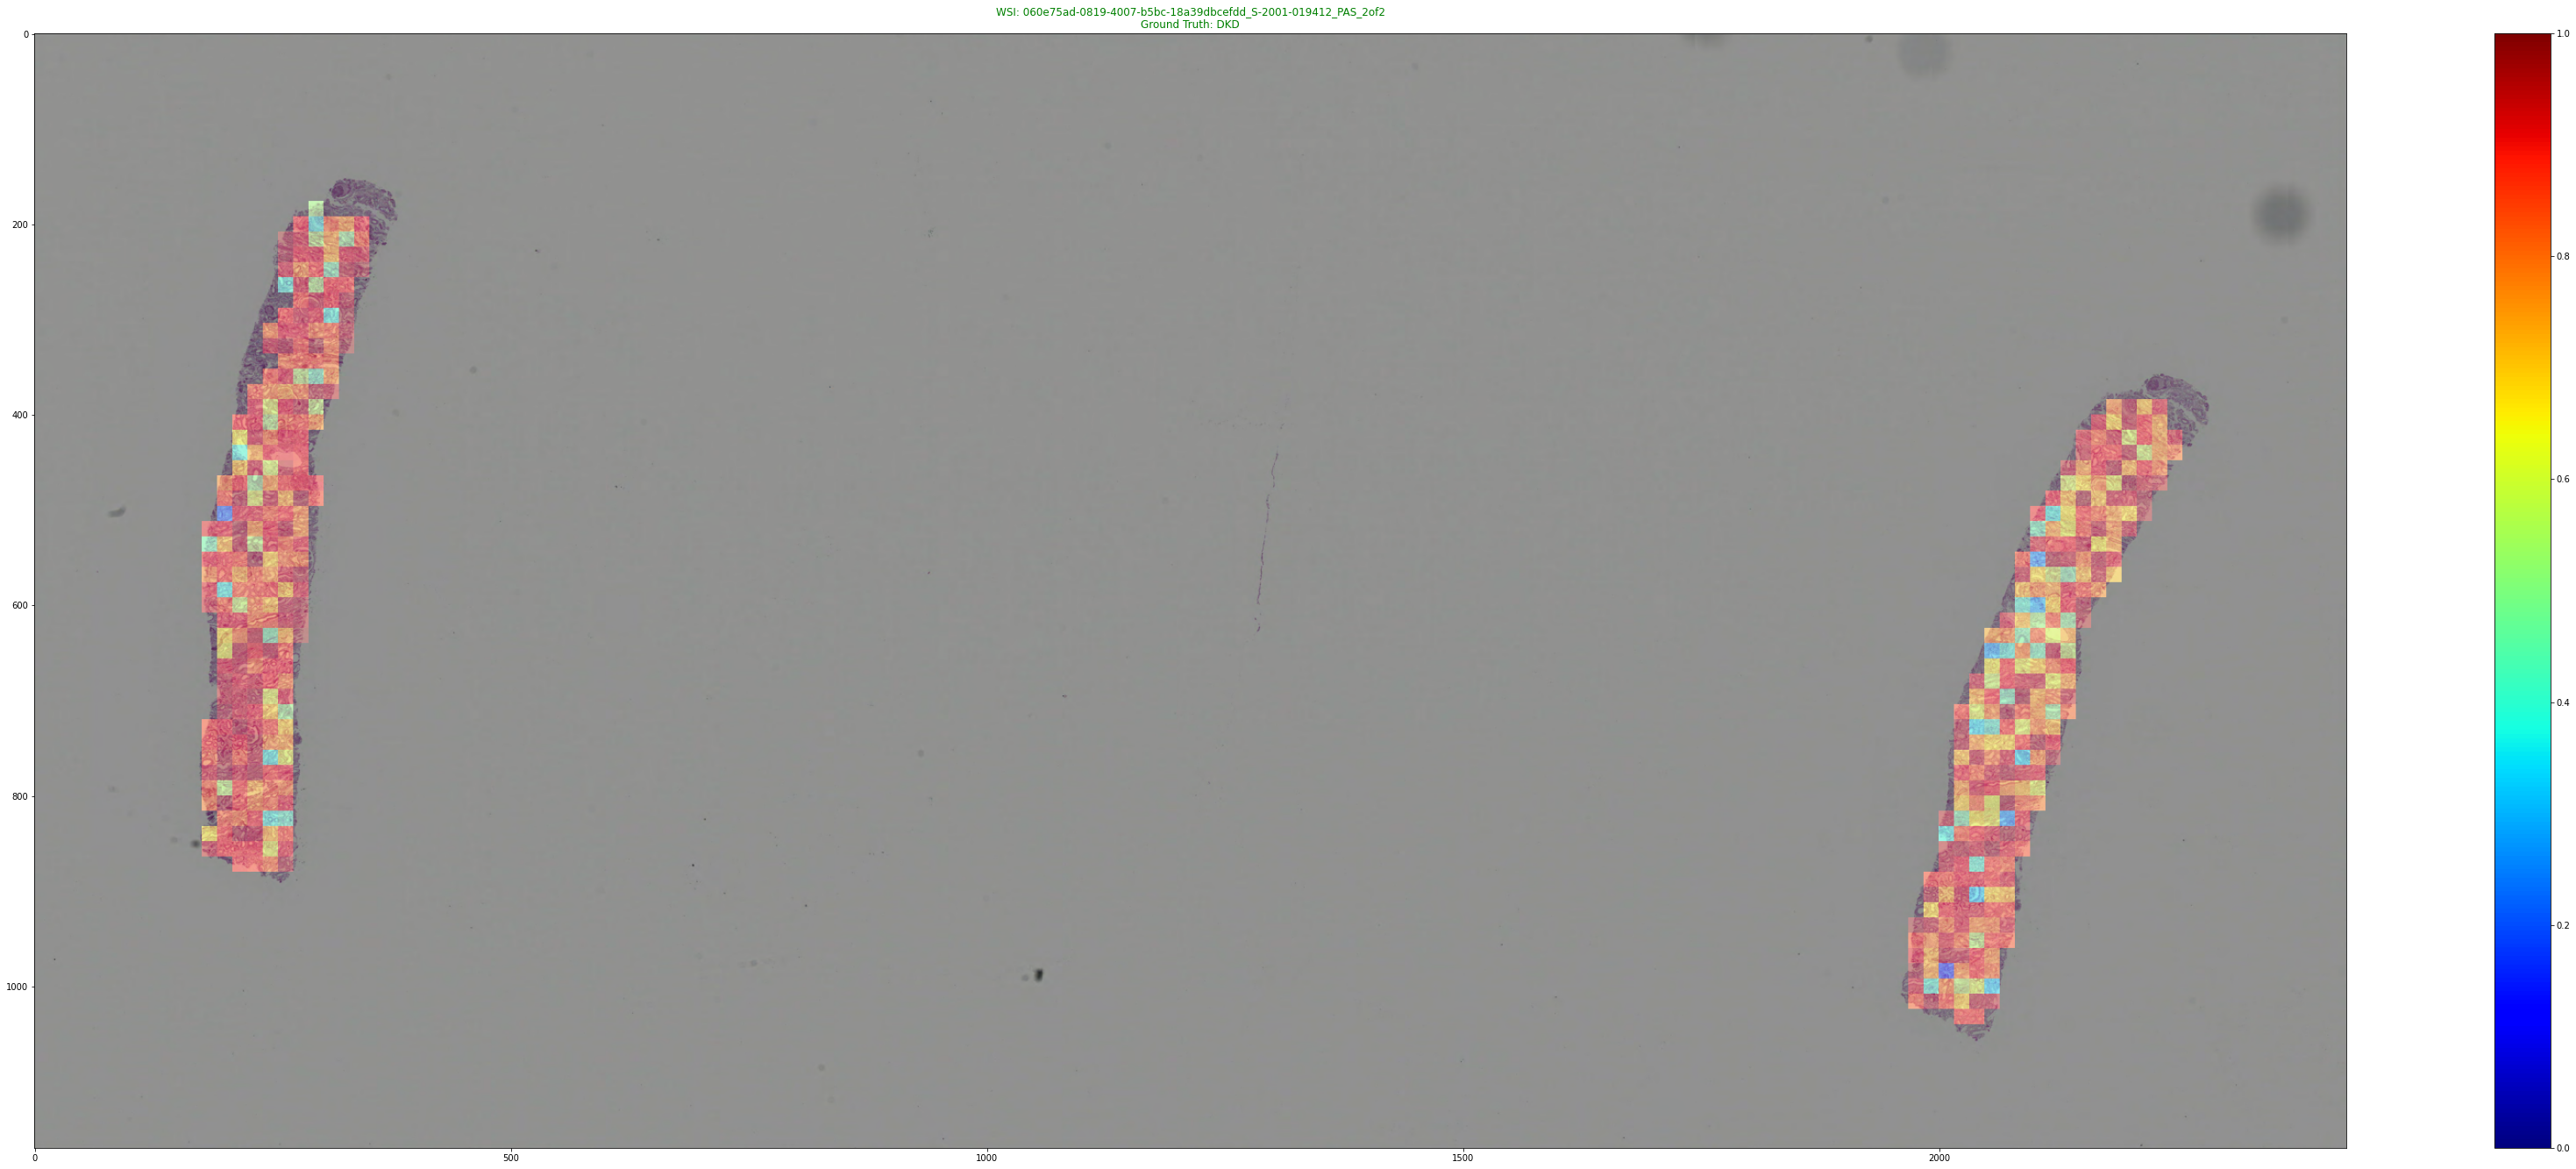

In [45]:
import matplotlib
import matplotlib.pyplot as plt
def heatmap_probability_generation(model,wsi_name,label):
    SCALE_FACTOR=32
    wsi_path = '/data1/DKDimages/ALL_WSI/'+wsi_name+'.svs'
    print(wsi_path)
    print(os.path.exists(wsi_path))
    wsi_image = OpenSlide(wsi_path)
    # pilImage = Image.open(wsi_path)
    img = openslide.OpenSlide(wsi_path)
    ds_img, large_w, large_h, new_w, new_h = slide_to_scaled_pil_image(img, SCALE_FACTOR)
    ds_img.save("test.png")
    # image = openslide.open_slide(wsi_path)
    # new_IM = Image.convert(image)
    # print(image.dimensions)
    path_sum = 0
    
    print(wsi_image.dimensions)
    print(ds_img.size)
    target_size = ds_img.size
    heat_map = Image.new('RGB', target_size)
    tsv_loc = '/data1/DKDimages/Pyhist_WSI_Image_Coords/' + wsi_name+ '/tile_selection.tsv'
    print(os.path.exists(tsv_loc))
    patch_loc = '/data1/DKDimages/All_patch_Folders/' + wsi_name+'_tiles/*'
    print(patch_loc)
    print(os.path.exists(patch_loc))
    tsv_coords = pd.read_csv(tsv_loc,sep='\t')
    # print(tsv_coords)
    # print(glob.glob(patch_loc+'/*'))
    temp = newSet(patch_loc,labels_wsi = label,transform=data_transforms)
    # print(len(temp))
    # image_datasets_test_new = tempFolder('/data1/DKDimages/All_patch_Folders/502d2911-4815-44e0-b66f-b1910e8808e9_S-1910-000043_PAS_1of2_tiles',labels = label,transform = data_transforms)
    dataloader_test_new = torch.utils.data.DataLoader(temp, batch_size=4,
                                             shuffle=False, num_workers=8)  
    model.eval()
    norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
    cmap = matplotlib.cm.get_cmap('jet')
    
    plt_colors = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
    print(matplotlib.cm.jet(norm(0.4), bytes = True))
     
    # img_color.save("img_color.png")
    # matplotlib.view_colormap(plt_colors)
    with torch.no_grad():
        for i, data in enumerate(dataloader_test_new):
            inputs, labels, filenames = data
            # print(inputs,labels,filenames)
            # print(type(labels))
            inputs = inputs.to(device)
            labels = labels.to(device)
              

            outputs = model(inputs)
            
            _, preds = torch.max(outputs, 1)
            probabilites = torch.sigmoid(outputs)
            # print(preds)
            try:
                if filenames[0]:
                    if label == 'DKD':
                        compare = probabilites[0][1]
                    elif label == 'HEALTHY':
                        compare = probabilites[0][2]
                    elif label == 'CKD_noDM':
                        compare = probabilites[0][0]
                    path_sum+=1
                    print(compare)
                    compare = compare.cpu()
                    color_val = matplotlib.cm.jet(norm(compare), bytes = True)
                    
                    print("path 0", filenames[0])
                    print("prediction probability: ", torch.sigmoid(outputs))
                    print(compare) 
                    print("prediction: ", class_names[preds[0]])
                    temp = filenames[0].split("/")[-1].split(".")[0]
    #                 dict_key = temp[0]+"_"+temp[1]+"_"+temp[2]+"_"+temp[3]
                    dict_key = temp
                    # print(dict_key)

                    if class_names[preds[0]] == "Has_DKD":
                        # heat = np.full(shape=(512, 512,3),fill_value=(0,0,255)).astype(np.uint32)
                        # heat = Image.fromarray((heat * 255).astype(np.uint8)) 
                        heat = Image.new('RGB',(int(512/SCALE_FACTOR),int(512/SCALE_FACTOR)),color_val)
                    elif class_names[preds[0]] == "HEALTHY":
                        # heat = np.full(shape=(512, 512,3),fill_value=(0,255,0)).astype(np.uint32)
                        # heat = Image.fromarray((heat * 255).astype(np.uint8))
                        heat = Image.new('RGB',(int(512/SCALE_FACTOR),int(512/SCALE_FACTOR)),color_val) 
                    elif class_names[preds[0]] == "CKD_noDM":
                        # heat = np.full(shape=(512, 512,3),fill_value=(255,0,0)).astype(np.uint32)
                        # heat = Image.fromarray((heat * 255).astype(np.uint8))
                        heat = Image.new('RGB',(int(512/SCALE_FACTOR),int(512/SCALE_FACTOR)),color_val) 
                    # heat = Image.new('RGB',(512,512),(255,0,0))
                    # heat.save("just_img.png")
                    if (tsv_coords[tsv_coords["Tile"] == (dict_key)]['Keep'].iloc[0] == 1):
                        
                        x = int((tsv_coords[tsv_coords["Tile"] == (dict_key)]['Column'].iloc[0])*int(512)/SCALE_FACTOR)
                        y = int((tsv_coords[tsv_coords["Tile"] == (dict_key)]['Row'].iloc[0])*int(512)/SCALE_FACTOR)
                        # print((tsv_coords[tsv_coords["Tile"] == (dict_key)]['Keep'].iloc[0])) 
                        heat_map.paste(im=heat, box=(x,y))

                    # print(x,y)
            except IndexError:
                pass
            try:
                
                if filenames[1]:
                    if label == 'DKD':
                        compare = probabilites[1][1]
                    elif label == 'HEALTHY':
                        compare = probabilites[1][2]
                    elif label == 'CKD_noDM':
                        compare = probabilites[1][0]
                    path_sum+=1
                    print("path 1", filenames[1])
                    print("prediction probability: ", torch.sigmoid(outputs)) 
                    print(compare) 
                    print("prediction: ", class_names[preds[1]])
                    temp = filenames[1].split("/")[-1].split(".")[0]
                    dict_key = temp
                    # print(dict_key)                
                    compare = compare.cpu()
                    color_val = matplotlib.cm.jet(norm(compare), bytes = True)
                    if class_names[preds[1]] == "Has_DKD":
                        #  heat = np.full(shape=(512, 512,3),fill_value=(0,0,255)).astype(np.uint32)
                        #  heat = Image.fromarray((heat * 255).astype(np.uint8))
                         heat = Image.new('RGB',(int(512/SCALE_FACTOR),int(512/SCALE_FACTOR)),color_val) 
                    elif class_names[preds[1]] == "HEALTHY":
                        #  heat = np.full(shape=(512, 512,3),fill_value=(0,255,0)).astype(np.uint32)
                        #  heat = Image.fromarray((heat * 255).astype(np.uint8))
                         heat = Image.new('RGB',(int(512/SCALE_FACTOR),int(512/SCALE_FACTOR)),color_val) 
                    elif class_names[preds[1]] == "CKD_noDM":
                        #  heat = np.full(shape=(512, 512,3),fill_value=(255,0,0)).astype(np.uint32)
                        #  heat = Image.fromarray((heat * 255).astype(np.uint8))
                         heat = Image.new('RGB',(int(512/SCALE_FACTOR),int(512/SCALE_FACTOR)),color_val) 
                    
                    if (tsv_coords[tsv_coords["Tile"] == (dict_key)]['Keep'].iloc[0] == 1):
                        
                        x = int((tsv_coords[tsv_coords["Tile"] == (dict_key)]['Column'].iloc[0])*int(512)/SCALE_FACTOR)
                        y = int((tsv_coords[tsv_coords["Tile"] == (dict_key)]['Row'].iloc[0])*int(512)/SCALE_FACTOR)
                        # print((tsv_coords[tsv_coords["Tile"] == (dict_key)]['Keep'].iloc[0])) 
                        heat_map.paste(im=heat, box=(x,y))
                    
    #             print(filenames[2])
            except IndexError:
                pass
            try:
                if filenames[2]:
                    if label == 'DKD':
                        compare = probabilites[2][1]
                    elif label == 'HEALTHY':
                        compare = probabilites[2][2]
                    elif label == 'CKD_noDM':
                        compare = probabilites[2][0]
                    path_sum+=1
                    
                    print("path 2", filenames[2])
                    print("prediction probability: ", torch.sigmoid(outputs)) 
                    print(compare) 
                    print("prediction: ", class_names[preds[2]])
                    temp = filenames[2].split("/")[-1].split(".")[0]
                    dict_key = temp
#                     dict_key = temp[0]+"_"+temp[1]+"_"+temp[2]+"_"+temp[3]
                    # print(dict_key)                    
                    compare = compare.cpu()
                    color_val = matplotlib.cm.jet(norm(compare), bytes = True)
                    if class_names[preds[2]] == "Has_DKD":
                        # heat = np.full(shape=(512, 512,3),fill_value=(0,0,255)).astype(np.uint32)
                        # heat = Image.fromarray((heat * 255).astype(np.uint8))
                        heat = Image.new('RGB',(int(512/SCALE_FACTOR),int(512/SCALE_FACTOR)),color_val) 
                    elif class_names[preds[2]] == "HEALTHY":
                        # heat = np.full(shape=(512, 512,3),fill_value=(0,255,0)).astype(np.uint32)
                        # heat = Image.fromarray((heat * 255).astype(np.uint8))
                        heat = Image.new('RGB',(int(512/SCALE_FACTOR),int(512/SCALE_FACTOR)),color_val) 
                    elif class_names[preds[2]] == "CKD_noDM":
                        # heat = np.full(shape=(512, 512,3),fill_value=(255,0,0)).astype(np.uint32)
                        # heat = Image.fromarray((heat * 255).astype(np.uint8))
                        heat = Image.new('RGB',(int(512/SCALE_FACTOR),int(512/SCALE_FACTOR)),color_val) 
                    
                    if (tsv_coords[tsv_coords["Tile"] == (dict_key)]['Keep'].iloc[0] == 1):
                        
                        x = int((tsv_coords[tsv_coords["Tile"] == (dict_key)]['Column'].iloc[0])*int(512)/SCALE_FACTOR)
                        y = int((tsv_coords[tsv_coords["Tile"] == (dict_key)]['Row'].iloc[0])*int(512)/SCALE_FACTOR)
                        print((tsv_coords[tsv_coords["Tile"] == (dict_key)]['Keep'].iloc[0])) 
                        heat_map.paste(im=heat, box=(x,y))  
            except IndexError:
                pass

            try:
                if filenames[3]:
                    if label == 'DKD':
                        compare = probabilites[3][1]
                    elif label == 'HEALTHY':
                        compare = probabilites[3][2]
                    elif label == 'CKD_noDM':
                        compare = probabilites[3][0]
                    path_sum+=1
                    print("path 3", filenames[3])
                    print("prediction probability: ", torch.sigmoid(outputs)) 
                    print(compare) 
                    print("prediction: ", class_names[preds[3]])
                    temp = filenames[3].split("/")[-1].split(".")[0]
                    dict_key = temp
#                     dict_key = temp[0]+"_"+temp[1]+"_"+temp[2]+"_"+temp[3]
                    # print(dict_key)
                    compare = compare.cpu()
                    color_val = matplotlib.cm.jet(norm(compare), bytes = True)
                    if class_names[preds[3]] == "Has_DKD":
                        # heat = np.full(shape=(512, 512, 3),fill_value=(0,0,255)).astype(np.uint32)
                        # heat = Image.fromarray((heat * 255).astype(np.uint8))
                        heat = Image.new('RGB',(int(512/SCALE_FACTOR),int(512/SCALE_FACTOR)),color_val)
                    elif class_names[preds[3]] == "HEALTHY":
                        # heat = np.full(shape=(512, 512, 3),fill_value=(0,255,0)).astype(np.uint32)
                        # heat = Image.fromarray((heat * 255).astype(np.uint8))
                        heat = Image.new('RGB',(int(512/SCALE_FACTOR),int(512/SCALE_FACTOR)),color_val)
                    elif class_names[preds[3]] == "CKD_noDM":
                        # heat = np.full(shape=(512, 512, 3),fill_value=(255,0,0)).astype(np.uint32)
                        # heat = Image.fromarray((heat * 255).astype(np.uint8))
                        heat = Image.new('RGB',(int(512/SCALE_FACTOR),int(512/SCALE_FACTOR)),color_val)
                    
                    if (tsv_coords[tsv_coords["Tile"] == (dict_key)]['Keep'].iloc[0] == 1):
                        
                        x = int((tsv_coords[tsv_coords["Tile"] == (dict_key)]['Column'].iloc[0])*int(512)/SCALE_FACTOR)
                        y = int((tsv_coords[tsv_coords["Tile"] == (dict_key)]['Row'].iloc[0])*int(512)/SCALE_FACTOR)
                        print((tsv_coords[tsv_coords["Tile"] == (dict_key)]['Keep'].iloc[0])) 
                        heat_map.paste(im=heat, box=(x,y))
                    
            except IndexError:
                pass
        heat_map.save('mask.png')
        px = 1/plt.rcParams['figure.dpi']  # pixel in inches
        plt.subplots(figsize=(4359*px, 1683*px))
        downsampled_img = Image.blend(ds_img, heat_map, 0.4)
        plt.rc('figure', titlesize = 1200)
        plt.title("WSI: " + wsi_name +'\n' + "Ground Truth: " + label, color = 'green')
        plt.imshow(downsampled_img)
        plt.colorbar(plt_colors)
        
        plt.savefig('heatmap_colorbar.png')
        downsampled_img.save("heatmap_probability.png")
        print(path_sum)
        
        
test_list = df_labels["filenames"].tolist()
print(test_list[9])
wsi_label = df_labels[df_labels["filenames"] == (test_list[9])]['labels'].iloc[0]
print(wsi_label)
model = torch.load(PATH)
model.eval()
heatmap_probability_generation(model,test_list[9],wsi_label) 